## Example 1: Flipping Coins
**Lecture:** Bayesian Statistical Inference

**Date:** 22/11/23

**Course:** Statistical Estimation for Physics

*Summary:* In this first example, we will illustrate a number of simple concepts regarding Bayesian inference: definiing priors and likelihoods, computing posteriors, and understanding the behaviour of the likelihood/posterior as we re-sample data.

*Model:* The model is simple: it has one model parameter $\theta = p_\mathrm{heads}$ that we want to infer. Then, we assume the we observe $n_\mathrm{flips}$ and note down the individual flip results (as opposed to e.g. just counting the number of heads and tails). This is our data $x = [\mathrm{H}, \mathrm{T}, ...]$. In terms of a likelihood, this translates into:

$$p(x = [F_1, F_2, F_3, ...] \, | \, \theta) = \theta^{\sum_i{F_i}} \times (1 - \theta)^{n_\mathrm{flips} - \sum_i{F_i}}$$

where $F_i = 0, 1$ if the $i^\mathrm{th}$ flip is a tail or a head respectively. Finally, we choose a prior $\theta \sim \mathrm{U}(0, 1)$ over the model parameter, encoding the fact that initially we have no idea what the bias of the coin is.

### Imports

In [1]:
#!pip install numpy matplotlib jax jaxlib
# Uncomment the above line to install the packages
import time
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

plt.style.use("lecture.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Definitions of the prior, likelihood, and posterior classes

**Programming Note:** Note that we are using `jax` to code up the distributions here, this allows for `jit`-compilation of e.g. the density functions for fast evaluation

**Programming Note:** There is a subtelty on the coding side here as we increase $n_\mathrm{flips}$ in that the likelihood $p(x | \theta)$ will tend to become extremely small. At a certain point, this will exceed machine precision and we will need to approach it differently. See the exercises at the bottom of the notebook for more on this.

In [2]:
class Prior:
    def __init__(self, p_min=0.0, p_max=1.0):
        self.name = "prior"
        self.min = p_min
        self.max = p_max

    @partial(jax.jit, static_argnums=(0,))
    def density(self, theta):
        return (
            (1.0 / (self.max - self.min))
            * jnp.heaviside(theta - self.min, 1.0)
            * jnp.heaviside(self.max - theta, 1.0)
        )

    def sample(self, size):
        return jax.random.uniform(jax.random.PRNGKey(time.time_ns()), shape=(size,), minval=self.min, maxval=self.max)

class Likelihood:
    def __init__(self, nflips):
        self.name = "likelihood"
        self.nflips = nflips
        if self.nflips > 100:
            print("Warning: large number of flips, this is unlikely to be numerically stable. Consider implementing the log likelihood instead.")

    @partial(jax.jit, static_argnums=(0,))
    def density(self, x, theta):
        return jnp.power(theta, jnp.sum(x)) * jnp.power(1.0 - theta, self.nflips - jnp.sum(x)) * jnp.heaviside(theta, 1.0) * jnp.heaviside(1.0 - theta, 1.0)

    def sample(self, theta):
        if theta > 1.0 or theta < 0.0:
            return ValueError("theta must be between 0 and 1")
        return 1*jax.random.bernoulli(jax.random.PRNGKey(time.time_ns()), p=theta, shape=(self.nflips,))
    
    def print_sample(self, x):
        string = r"|"
        for i in x:
            string += r" H |" * i + r" T |" * (1 - i)
        string += r"    (n = " + str(self.nflips) + r")"
        return string

class Posterior:
    def __init__(self, prior, likelihood):
        self.name = "posterior"
        self.prior = prior
        self.likelihood = likelihood

    @partial(jax.jit, static_argnums=(0,))
    def density(self, theta, x):
        return self.prior.density(theta) * self.likelihood.density(x, theta)

### Prior sampling check
Let's just do a quick check of the prior sampling to make sure we reproduce the uniform distribution

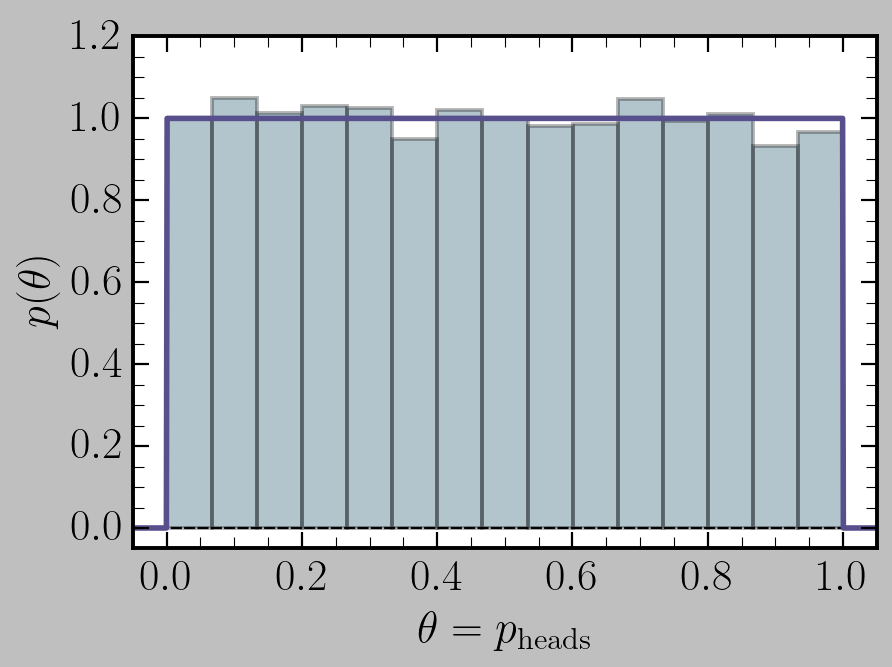

In [3]:
prior = Prior()
theta_sample = prior.sample(10000)
theta_arr = jnp.linspace(prior.min - 0.05, prior.max + 0.05, 1000)

plt.axhline(0, color="black", lw=1, ls=(1, (5, 1)))
plt.hist(theta_sample, bins=15, density=True, alpha=0.3)
plt.plot(theta_arr, prior.density(theta_arr))
plt.xlabel(r"$\theta = p_\mathrm{heads}$")
plt.ylabel(r"$p(\theta)$")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.2)
plt.show()

### Likelihood evaluation

Now let's focus on the likelihood itself. We will do the following exercise, let's fix $\theta = 0.5$ and generate a number of data realisations $x_k \sim p(x | \theta = 0.5)$. Then, we can profile the likelihood $p(x_k | \theta)$ on a grid of $\theta \in [0, 1]$. This raises a relatively simple, but important point that can be easily overlooked when analysing real, fixed data $x_\mathrm{obs}$. Importantly, we see that for different realisations of the data, the likelihood profile shifts somewhat as a function of $\theta$.

### **Exercise:** Can you explain the discreteness in the different classes of curve? How many should there be? How does this depend on $n_\mathrm{flips}$?

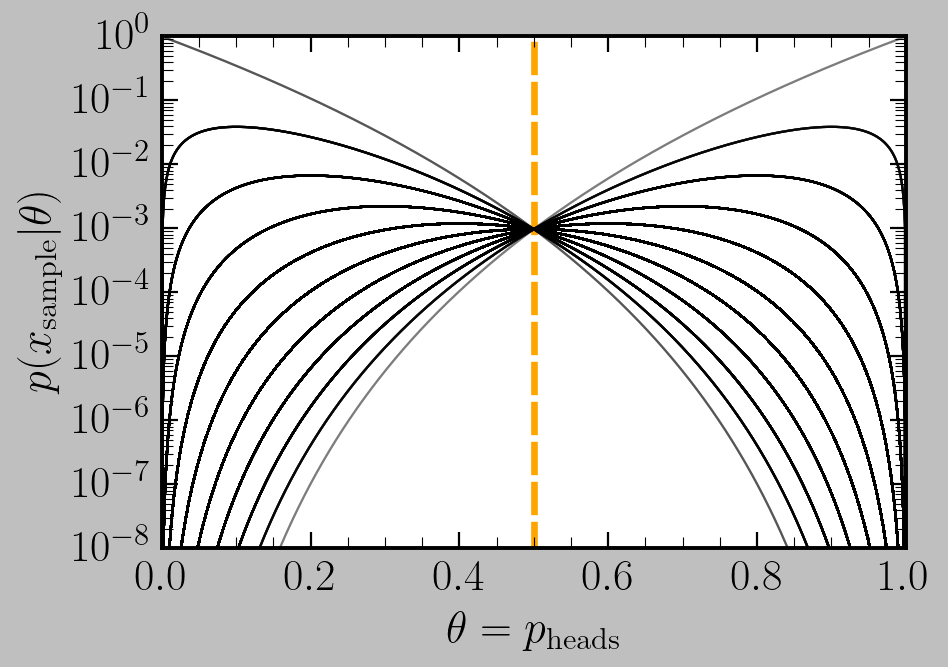

In [4]:
likelihood = Likelihood(nflips=10)

printing = False
for i in range(1000):
    x_sample = likelihood.sample(theta=0.5)
    if printing:
        print(likelihood.print_sample(x_sample))

    theta_arr = jnp.linspace(0.0, 1.0, 1000)
    like_arr = likelihood.density(x_sample, theta_arr)
    plt.plot(theta_arr, like_arr, c="black", lw=1, alpha=0.3)
plt.axhline(0, color="black", lw=1, ls=(1, (5, 1)))
plt.axvline(0.5, color="orange", lw=3, ls=(1, (5, 1)), zorder=-10)
plt.xlabel(r"$\theta = p_\mathrm{heads}$")
plt.ylabel(r"$p(x_\mathrm{sample} | \theta)$")
plt.xlim(0.0, 1.0)
plt.ylim(1e-8,)
plt.yscale('log')
plt.show()

### Posterior Evaluation

Finally we can actually perform inference. As you can see in the `Posterior` class above, for a fixed observation $x_0$, we can easily compute the (unnormalised) posterior density by taking the product of the prior and the likelihood as a function of $\theta$. We show this below for $n_\mathrm{flips} = 10$ and data generated from a distribution with true value $\theta = 0.5$.

### **Exercise:** Run this block multiple times (i.e. resample the data), how does the posterior shift around? Can you relate that to the behaviour of the likelihood above? What happens if you vary the injection value of $\theta$?

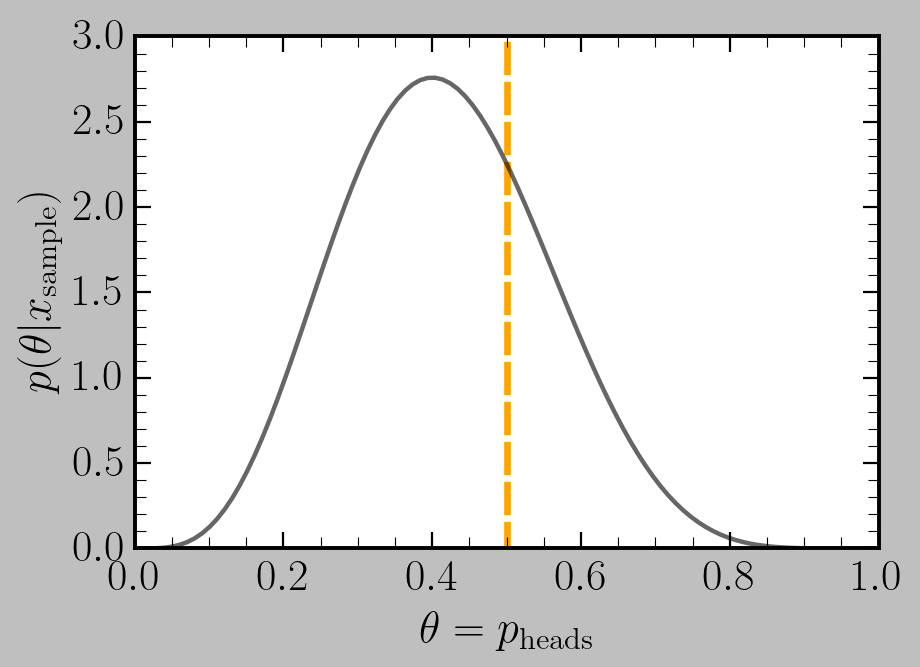

In [5]:
posterior = Posterior(prior=Prior(), likelihood=Likelihood(nflips=10))
x_sample = posterior.likelihood.sample(theta=0.5)
theta_arr = jnp.linspace(0.0, 1.0, 100)
post_arr = posterior.density(theta_arr, x_sample)
normalisation = jnp.trapz(post_arr, theta_arr)
plt.plot(theta_arr, post_arr / normalisation, c="black", lw=2, alpha=0.6)
plt.xlabel(r"$\theta = p_\mathrm{heads}$")
plt.ylabel(r"$p(\theta | x_\mathrm{sample})$")
plt.axvline(0.5, color="orange", lw=3, ls=(1, (5, 1)), zorder=-10)
plt.show()

### Varying the number of flips

Let's try increasing the number of flips, intuitively this should lead to much better constraints on the inferred value of $\theta$, and indeed it does.

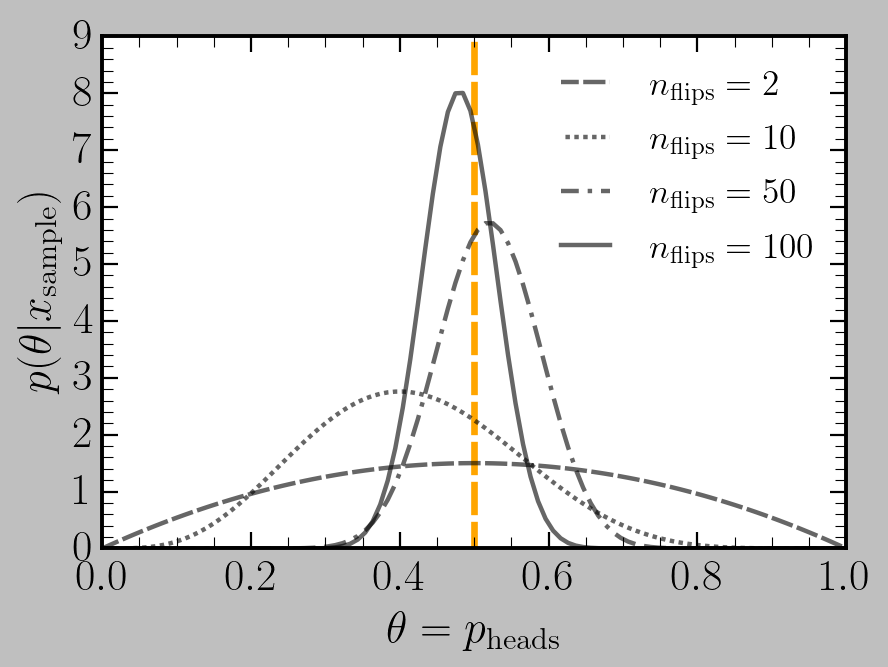

In [6]:
ls_arr = [(1, (5, 1)), (1, (1, 1)), (1, (5, 2, 1, 2, 5, 2)), '-']
for idx, nflips in enumerate([2, 10, 50, 100]):
    posterior = Posterior(prior=Prior(), likelihood=Likelihood(nflips=nflips))
    x_sample = posterior.likelihood.sample(theta=0.5)
    theta_arr = jnp.linspace(0.0, 1.0, 100)
    post_arr = posterior.density(theta_arr, x_sample)
    normalisation = jnp.trapz(post_arr, theta_arr)
    plt.plot(theta_arr, post_arr / normalisation, c="black", lw=2, alpha=0.6, label=r"$n_\mathrm{flips} =" + rf"{nflips}$", ls=ls_arr[idx])
plt.axvline(0.5, color="orange", lw=3, ls=(1, (5, 1)), zorder=-10)
plt.xlabel(r"$\theta = p_\mathrm{heads}$")
plt.ylabel(r"$p(\theta | x_\mathrm{sample})$")
plt.legend(fontsize=16)
plt.show()

### **Exercise:** Try plugging in $n_\mathrm{flips} = 1000$, what happens? How can you evaluate the posterior in a more robust way (hint: consider computing $\log p(x | \theta)$)?
### **Exercise:** How could you check that the posterior is behaving correctly as you vary the data? (Hint: try checking how often the true value is contained in e.g. the 68\% confidence interval of the posterior, how often should this be the case?)